In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score

from riskyneuroarousal.modeling.behavioral_models import convert_subjective
from riskyneuroarousal.utils.load_data import load_behavioral_data

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# false discovery control
from scipy.stats import false_discovery_control

In [2]:
x = []
for file in os.listdir():
    if file.split("_")[0] == "EV" or file.split("_")[0] == "CPT":
        if file.split("_")[-2] == "subjectFit":
            x.append(pd.read_csv(file))
model_fits = pd.concat(x, ignore_index=True)

In [ ]:
data = load_behavioral_data(min_RT = 0.2)
data['history'] = data.groupby('sub')['accept'].shift(1).fillna(0).astype(int)

In [4]:
subs_df = {m : [] for m in model_fits["model"].unique()}
for m in subs_df.keys():
    for sub in data["sub"].unique():
        params = model_fits.query(f"sub == {sub} & model == '{m}'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
        df2 = convert_subjective(data.query(f"sub == {sub}").reset_index(), params, model = m)
        subs_df[m].append(df2)
    subs_df[m] = pd.concat(subs_df[m], axis=0)

In [5]:
print("Performance")
res_model_per = {"model": [], "acc" : [], "sub" : []}
for m in subs_df:
    model_sub_df = subs_df[m]
    for s in model_sub_df["sub"].unique():
        model_sub_df_s = model_sub_df.query(f"sub == {s}")
        res_model_per["model"].append(m)
        res_model_per["acc"].append(np.mean(model_sub_df_s["accept"] == model_sub_df_s["accept_pred"]))
        res_model_per["sub"].append(s)

res_model_per = pd.DataFrame(res_model_per)

Performance


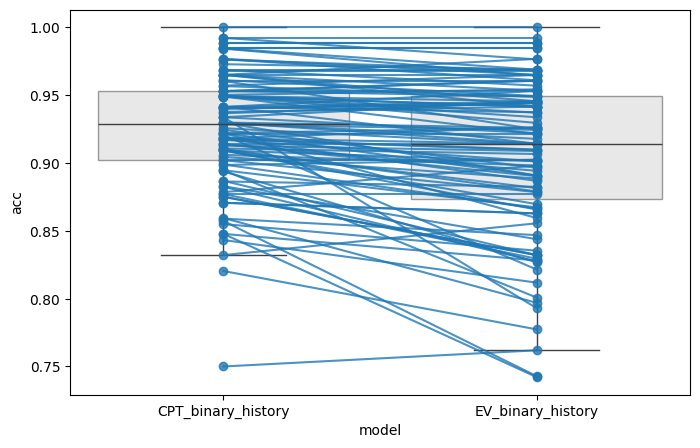

In [6]:
plt.figure(figsize=(8, 5))

# Box plot
sns.boxplot(data=res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}"), x='model', y='acc', showcaps=True,
            boxprops={'facecolor':'lightgray', 'alpha':0.5}, showfliers=False)

# Dot and line plot per subject
palette = {'CPT_binary_history': '#1f77b4', 'EV_binary_history': '#ff7f0e'}
for sub, group in res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}").groupby('sub'):
    group_sorted = group.sort_values('model')  # ensure correct order
    plt.plot(group_sorted['model'], group_sorted['acc'], marker='o',
             label=sub, alpha=0.8, linewidth=1.5,
             color=palette[group_sorted['model'].iloc[0]])
plt.show()

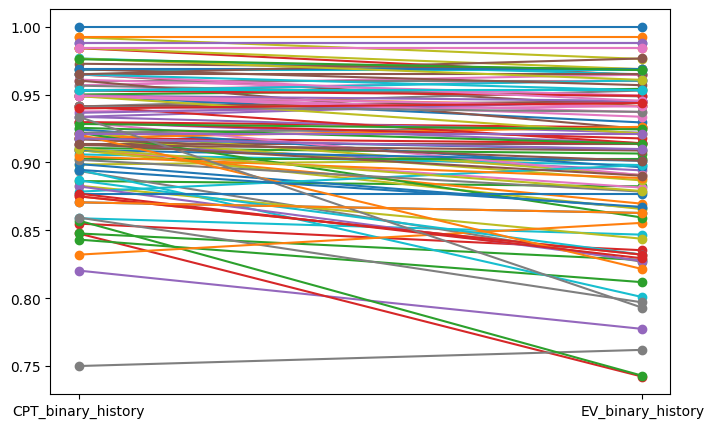

In [7]:
# Pivot the dataframe so each row is a sub and columns are models
pivot_df = res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}").pivot(index='sub', columns='model', values='acc')

# Plot
plt.figure(figsize=(8, 5))
for sub in pivot_df.index:
    plt.plot(pivot_df.columns, pivot_df.loc[sub], marker='o', label=sub)

plt.show()

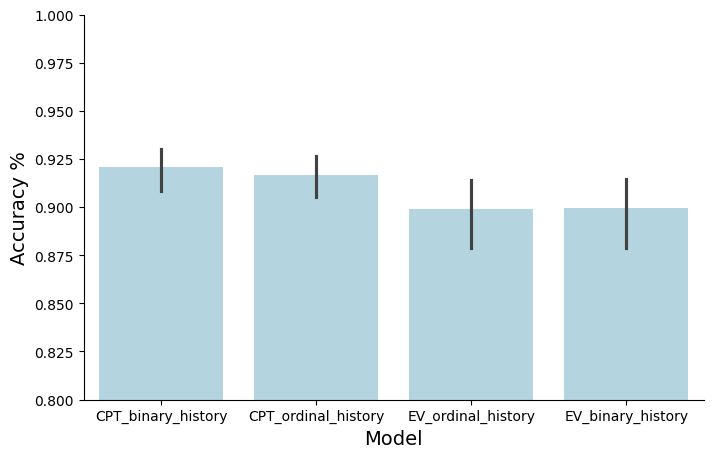

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(data = res_model_per, x = "model", y = "acc", color = "lightblue")
plt.ylim(0.8, 1)
sns.despine()
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy %", fontsize=14)
# Change the font type to Helvetica
# plt.xticks([0, 1, 2, 3], ["CPT binary", "CPT ordinal", "EV ordinal", "EV binary"], fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [9]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = res_model_per["model"].unique()[i]
            model2 = res_model_per["model"].unique()[j]
            data1 = res_model_per.query(f"model == '{model1}'")["acc"]
            data2 = res_model_per.query(f"model == '{model2}'")["acc"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")

p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")


Significant difference between CPT_ordinal_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.542194253511828
Significant difference between EV_ordinal_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.630213682183307
Significant difference between EV_ordinal_history vs CPT_ordinal_history with p-value: 0.0008698506798994999 and t-stat: -3.741684669948838
Significant difference between EV_binary_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.683136992648054
Significant difference between EV_binary_history vs CPT_ordinal_history with p-value: 0.0008698506798994999 and t-stat: -3.7580561632023493


In [50]:
for model in subs_df:
    model_sub_df = subs_df[model]
    # Create new column for normalized decision value grouped by sub
    model_sub_df["decision_value_norm"] = model_sub_df.groupby("sub")["decision_value"].transform(lambda x: x / np.max([abs(x.max()), abs(x.min())]))

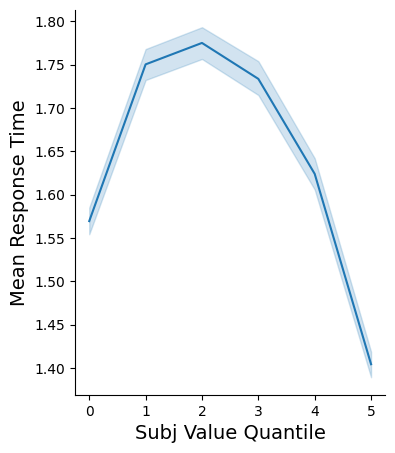

In [21]:
plt.figure(figsize=(4, 5))
r2_rt = {"model" : [], "r2" : [], "sub" : []}
for m in subs_df:
    if m != "CPT_ordinal_history":
        continue
    model_sub_df = subs_df[m]
    model_sub_df["bin_dv"] = model_sub_df.groupby("sub")["subj_value_norm"].transform(
                                                        lambda x: pd.qcut(x, q=6, labels=False, duplicates='drop')
                                                    )
    sns.lineplot(data = model_sub_df, x = "bin_dv", y = "RT")

    for sub in model_sub_df["sub"].unique():
        subsub_df = model_sub_df.query(f"sub == {sub}").reset_index()
        
        subsub_df["decision_value_sqred"] = subsub_df["subj_value_norm"] ** 2
        X = subsub_df[['subj_value', 'decision_value_sqred']]  # predictor needs to be 2D
        y = subsub_df['RT']

        model = LinearRegression().fit(X, y)
        r_squared = r2_score(y, model.predict(X))
        r2_rt["r2"].append(r_squared)
        r2_rt["model"].append(m)
        r2_rt["sub"].append(sub)

r2_rt = pd.DataFrame(r2_rt)
sns.despine()
plt.xlabel("Subj Value Quantile", fontsize=14)
plt.ylabel("Mean Response Time", fontsize=14)
plt.show()


In [15]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = r2_rt["model"].unique()[i]
            model2 = r2_rt["model"].unique()[j]
            if model1.split("_")[0] == "EV" and model2.split("_")[0] == "EV":
                continue
            data1 = r2_rt.query(f"sub != 56 & model == '{model1}'")["r2"]
            data2 = r2_rt.query(f"sub != 56 & model == '{model2}'")["r2"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")
p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")

Significant difference between CPT_ordinal_history vs CPT_binary_history with p-value: 0.0005466569918655244 and t-stat: 4.240156685929643
Significant difference between EV_ordinal_history vs CPT_ordinal_history with p-value: 0.0007120258265586722 and t-stat: -3.8718602045467563
Significant difference between EV_binary_history vs CPT_ordinal_history with p-value: 0.0007120258265586722 and t-stat: -3.8718602045467563


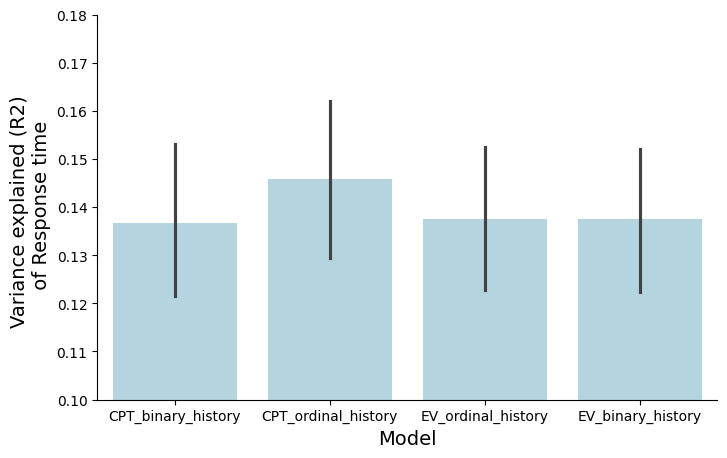

In [16]:
plt.figure(figsize=(8, 5))
sns.barplot(data = r2_rt, x = "model", y = "r2", color = "lightblue")
sns.despine()
plt.xlabel("Model", fontsize=14)
plt.ylabel("Variance explained (R2) \n of Response time", fontsize=14)
plt.ylim(0.10, 0.18)
# Change the font type to Helvetica
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

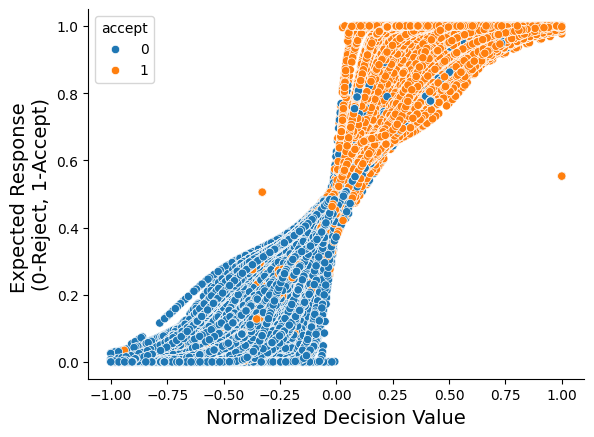

In [68]:
sns.scatterplot(data=subs_df["CPT_ordinal_history"], x = "decision_value_norm", y = "EV_R", hue = "accept")
plt.xlabel("Normalized Decision Value", fontsize=14)
plt.ylabel("Expected Response \n(0-Reject, 1-Accept)", fontsize=14)
sns.despine()

In [70]:
subs_df["CPT_ordinal_history"]

,index,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,...,prob_4,prob_3,prob_2,prob_1,EV_R,accept_pred,response_pred,subj_value_norm,bin_dv,decision_value_norm
0,0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,...,9.648551e-02,9.020258e-01,1.488638e-03,7.871162e-08,6.983322e-01,True,3,0.173792,3,0.121655
1,1,1,1,equalIndifference,34,14,2.289,1,4.0,strongly_accept,...,8.799892e-01,1.200108e-01,2.563756e-08,5.796822e-15,9.599964e-01,True,4,0.323984,4,0.223105
2,2,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,...,9.818930e-01,1.810696e-02,9.674831e-11,2.810252e-18,9.939643e-01,True,4,0.373630,4,0.260772
3,3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,...,2.609189e-04,7.886388e-01,2.100520e-01,1.048251e-03,5.960375e-01,True,3,-0.229519,1,0.032875
4,4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,...,1.110223e-16,3.077980e-05,4.150366e-02,9.584656e-01,1.385507e-02,False,1,-0.586540,0,-0.164119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,...,0.000000e+00,1.221245e-15,1.586412e-04,9.998414e-01,5.288040e-05,False,1,-0.566272,0,-0.516643
252,27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,...,0.000000e+00,2.277144e-07,2.340865e-01,7.659132e-01,7.802900e-02,False,1,-0.334781,1,-0.329067
253,27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,...,0.000000e+00,0.000000e+00,1.353770e-10,1.000000e+00,4.512568e-11,False,1,-0.781166,0,-0.693688
254,27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,...,0.000000e+00,1.875167e-13,1.612179e-03,9.983878e-01,5.373929e-04,False,1,-0.513926,1,-0.473895


Text(0, 0.5, 'Mean Estimate')

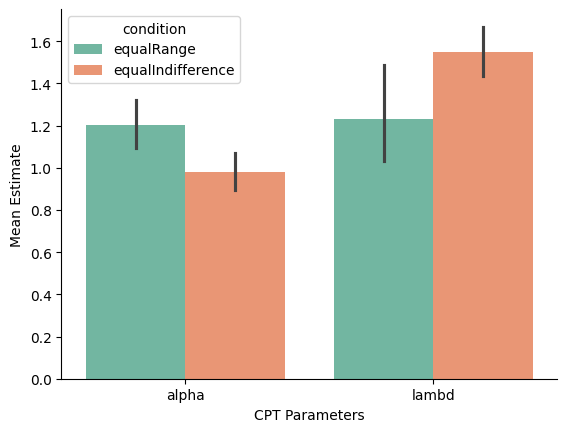

In [7]:
sns.barplot(data=model_fits.query(f"param_names in {['lambd', 'alpha']} & model == 'CPT_ordinal_history'"), x="param_names", y="estimates", hue="condition", palette='Set2')
sns.despine()
plt.xlabel('CPT Parameters')
plt.ylabel('Mean Estimate')

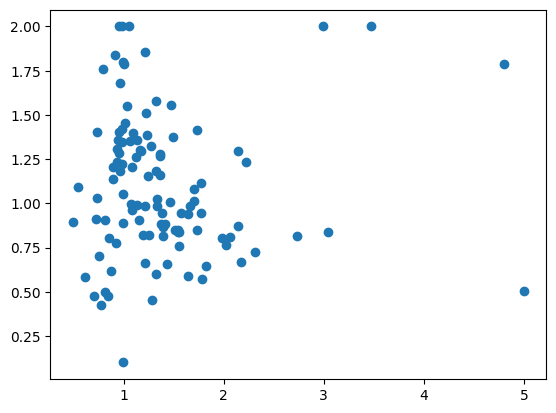

In [9]:
plt.scatter(model_fits.query("param_names == 'lambd' & model == 'CPT_ordinal_history'")['estimates'],
            model_fits.query("param_names == 'alpha' & model == 'CPT_ordinal_history'")['estimates'])

<Axes: xlabel='model', ylabel='estimates'>

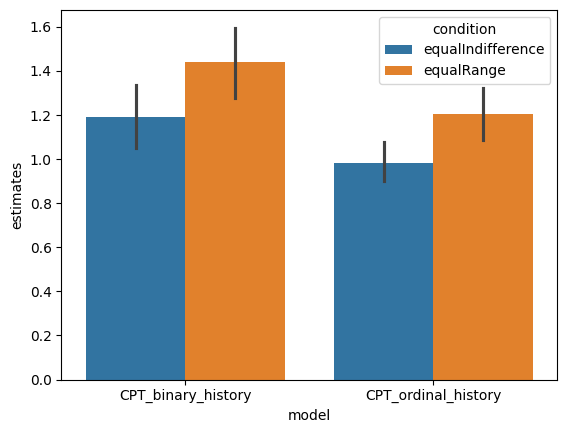

In [107]:
sns.barplot(data=model_fits.query(f"param_names in {['alpha']}"), x="model", y="estimates", hue="condition")

<Axes: xlabel='model', ylabel='estimates'>

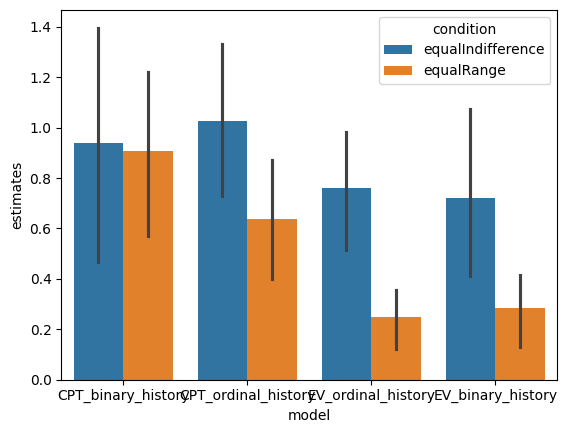

In [108]:
sns.barplot(data=model_fits.query(f"param_names in {['delta']}"), x="model", y="estimates", hue="condition")

In [60]:
for m in subs_df:
    model_sub_df = subs_df[m]
    data[f"SV_{m}"] = model_sub_df["decision_value"].values

In [73]:
data[f"SV_CPT_ordinal"] = subs_df["CPT_ordinal_history"]["decision_value"].values

In [74]:
data["decision_value_norm"] = subs_df["CPT_ordinal_history"]["decision_value_norm"].values

In [75]:
data

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,SV_CPT_ordinal,decision_value_norm
0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,1,2.392233,0.121655
1,1,1,equalIndifference,34,14,2.289,1,4.0,strongly_accept,2,4.387149,0.223105
2,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,3,5.127828,0.260772
3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4,0.646462,0.032875
4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5,-3.227237,-0.164119
...,...,...,...,...,...,...,...,...,...,...,...,...
27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,-8.321895,-0.516643
27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,-5.300491,-0.329067
27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,-11.173683,-0.693688
27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,-7.633334,-0.473895


In [76]:
data.to_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/behavioral_data_SVs.csv", index = False)

In [15]:
subs_df[m]

,index,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,...,history,SV_CPT_binary_history,SV_CPT_ordinal_history,SV_EV_ordinal_history,SV_EV_binary_history,decision_value,prob_1,prob_0,EV_R,accept_pred
0,0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,...,0,12.646122,0.981766,3.552182,3.889056,3.889056,1.000000e+00,1.572236e-08,1.000000e+00,True
1,1,1,1,equalIndifference,34,14,2.289,1,4.0,strongly_accept,...,1,28.778894,2.976682,10.043671,9.792730,9.792730,1.000000e+00,2.004220e-44,1.000000e+00,True
2,2,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,...,1,29.212578,3.717361,10.543671,10.292730,10.292730,1.000000e+00,7.347583e-49,1.000000e+00,True
3,3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,...,1,-2.656090,-0.764006,0.043671,-0.207270,-0.207270,3.840368e-01,6.159632e-01,3.840368e-01,False
4,4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,...,0,-14.741158,-4.637704,-3.947818,-3.610944,-3.610944,1.392021e-07,9.999999e-01,1.392021e-07,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,...,0,-11.637096,-7.171779,-4.626899,-4.593345,-4.593345,0.000000e+00,1.000000e+00,0.000000e+00,False
252,27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,...,0,-7.172968,-4.150374,-3.126899,-3.093345,-3.093345,0.000000e+00,1.000000e+00,0.000000e+00,False
253,27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,...,0,-13.733461,-10.023567,-6.126899,-6.093345,-6.093345,0.000000e+00,1.000000e+00,0.000000e+00,False
254,27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,...,0,-12.930133,-6.483217,-4.126899,-4.093345,-4.093345,0.000000e+00,1.000000e+00,0.000000e+00,False
